# INFSCI 0510 Final Exam
- Andrew Noonan
- April 16 2025

Importing libraries

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

loading csv

In [2]:
df = pd.read_csv('credit_card_transactions.csv')

## Task 1: K-Means Clustering

evaluating numeric features

In [3]:
df.head()

,transaction_id,account_number,transaction_type,transaction_amount,account_holder_country,purchase_country,credit_card_type,card_balance,card_limit,account_holder_income
0,1,221958,purchase,89.58,Mexico,Mexico,visa,1169.37,4727.91,69391.21
1,2,771155,cash_withdrawal,19.38,Canada,Canada,amex,1227.37,2651.14,46738.58
2,3,231932,online_payment,1685.34,USA,USA,mastercard,4582.76,7723.90,25337.63
3,4,465838,purchase,53.61,USA,USA,mastercard,928.94,3670.61,47987.03
4,5,359178,purchase,56.41,USA,USA,amex,905.34,5641.75,63439.96


In [4]:
df.dtypes

transaction_id              int64
account_number              int64
transaction_type           object
transaction_amount        float64
account_holder_country     object
purchase_country           object
credit_card_type           object
card_balance              float64
card_limit                float64
account_holder_income     float64
dtype: object

**Numeric features relevant for clustering**
- transaction_amount
- card_balance
- card_limit
- account_holder_income


In [5]:
scaler = StandardScaler()
 

scaling numeric features

In [6]:
df['account_holder_income'] = scaler.fit_transform(df[['account_holder_income']])
df['card_balance'] = scaler.fit_transform(df[['card_balance']])
df['card_limit'] = scaler.fit_transform(df[['card_limit']])
df['transaction_amount'] = scaler.fit_transform(df[['transaction_amount']])

**finding the optimal number of clusters**

In [7]:
data = df[['account_holder_income', 'card_balance', 'card_limit', 'transaction_amount']]
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_



/tmp/ipykernel_9987/4170478929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = kmeans.labels_
/tmp/ipykernel_9987/4170478929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clusters"] = kmeans.labels_
/tmp/ipykernel_9987/4170478929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [8]:
print(sse)

{1: 39999.99999999999, 2: 17879.057070651754, 3: 15823.296904075953, 4: 10912.111894683025, 5: 9499.668900952369, 6: 8154.025186017265, 7: 7655.094692702967, 8: 9775.424138888277, 9: 6516.665357273987, 10: 6256.876392600231}


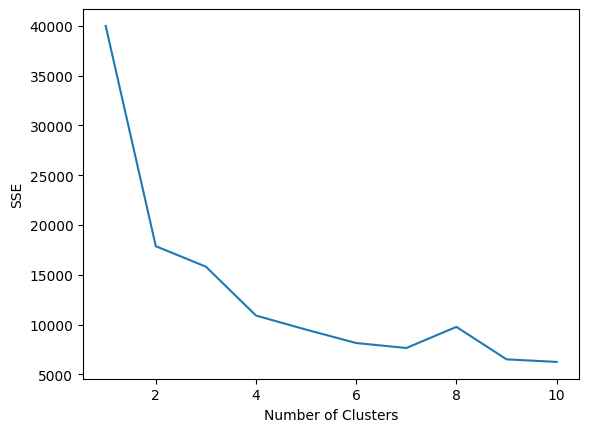

In [9]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

**Choosing the number of clusters based on the plot with the elbow method**
- based on the plot, it looks like k=3 would be the best choice for the number of clusters

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(data)
labels = kmeans.predict(data)
print(labels)

[1 1 0 ... 0 1 0]


In [11]:
df = pd.concat([df.reset_index(), pd.Series(labels).rename('fraud_cluster')], axis=1)

In [12]:
df.head()

,index,transaction_id,account_number,transaction_type,transaction_amount,account_holder_country,purchase_country,credit_card_type,card_balance,card_limit,account_holder_income,fraud_cluster
0,0,1,221958,purchase,-0.324700,Mexico,Mexico,visa,-0.248523,0.188132,1.409819,1
1,1,2,771155,cash_withdrawal,-0.424579,Canada,Canada,amex,-0.210902,-0.834921,-0.027763,1
2,2,3,231932,online_payment,1.945711,USA,USA,mastercard,1.965518,1.664008,-1.385910,0
3,3,4,465838,purchase,-0.375878,USA,USA,mastercard,-0.404474,-0.332713,0.051467,1
4,4,5,359178,purchase,-0.371894,USA,USA,amex,-0.419782,0.638305,1.032141,1


## Task 2: PCA Projection

In [14]:
pca = PCA(n_components=2)

In [15]:
principalComponents = pca.fit_transform(data)


In [16]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [17]:
principalDf.head()

,principal component 1,principal component 2
0,-3.349015,-0.695559
1,-1.318371,-0.770803
2,1.667153,3.501901
3,-1.339571,-0.622103
4,-3.376440,-0.457530


In [18]:
df[['fraud_cluster']].head()

,fraud_cluster
0,1
1,1
2,0
3,1
4,1


In [19]:
finalDf = pd.concat([principalDf, df[['fraud_cluster']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,fraud_cluster
0,-3.349015,-0.695559,1
1,-1.318371,-0.770803,1
2,1.667153,3.501901,0
3,-1.339571,-0.622103,1
4,-3.376440,-0.457530,1


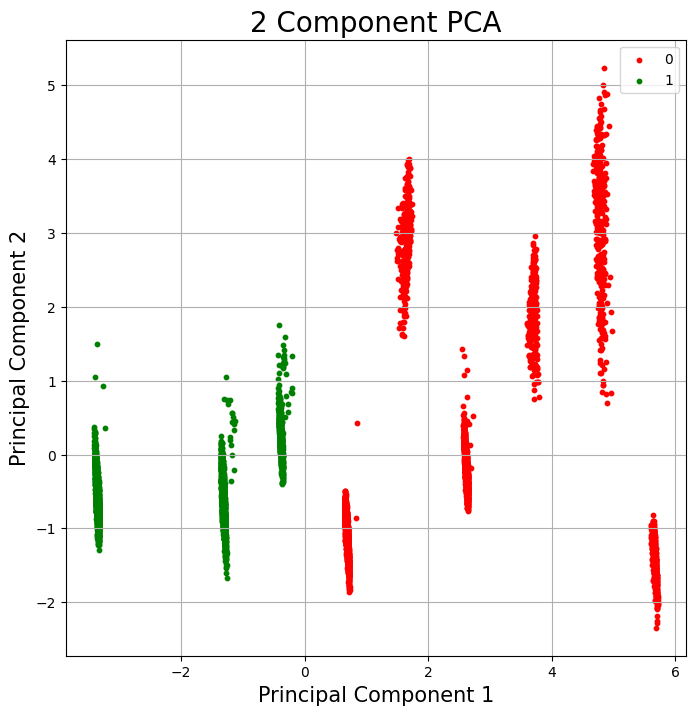

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['fraud_cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

The two classes appear very well separated

## Task 3: RandomForest Classification

In [26]:
X = df[['account_holder_income', 'card_balance', 'card_limit', 'transaction_amount']]
y = df['fraud_cluster']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [28]:
model = RandomForestClassifier(random_state=1, max_depth=10)


In [29]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=1)

In [38]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 1, 1, 1], shape=(2000,), dtype=int32)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       921
           1       0.99      0.99      0.99       955
           2       0.97      0.99      0.98       124

    accuracy                           0.99      2000
   macro avg       0.98      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [40]:
confusion_matrix(y_test, y_pred)

array([[910,   7,   4],
       [  8, 947,   0],
       [  1,   0, 123]])